# COMP4124 Lab 03: More DataFrames & Breaking Down Larger Problems

This lab has two main purposes:
* In Part 1, we walk you through a couple of further PySpark concepts (combining multiple DataFrames, recording the time it takes our code to run)
* In Part 2, we use the red fox GPS trace data as an example of how to break down a larger problem for solving using PySpark DataFrames.

There is also a short quiz on Moodle for you to complete. The purpose of this is to ensure you are familiar with the Moodle quiz interface in advance of the in-class test - please do complete this!

## Set-Up

**Install pyspark so can use within the notebook**

In [ ]:
!pip install pyspark

**Initialise the `SparkSession`**

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Lab03") \
    .getOrCreate()

sc = spark.sparkContext

In [ ]:
data_path = "/content/drive/My Drive/COMP4124_notebooks/24-25/data/"

In [ ]:
from pyspark.sql import functions as F
import pandas as pd
import time
import math

## Part 1: More PySpark concepts

### Load the red fox dataset

For some of our examples we are going to use the red fox GPS trace data. A cleaned version of the dataset `red_foxes_cleaned.csv` is available on Moodle alongside this lab - please use this file.
If you are unfamiliar with this dataset, please refer to the Tutorial files from Friday 14/02/2025 on Moodle for some explanation of the attributes.

The original dataset was downloaded from Movebank.

> Porteus TA, Short MJ, Hoodless AN, Reynolds JC. 2024. Data from: Study "Red Fox (Vulpes vulpes) in UK wet grasslands". Movebank Data Repository. https://doi.org/10.5441/001/1.304

In [ ]:
fox_df = spark.read.csv(data_path+'red_foxes_cleaned.csv', header=True)
fox_df.show(5, truncate=False)
fox_df.printSchema()

+-----------+-----------------------+-------------+------------+--------------------+---------------------------+
|event-id   |timestamp              |location-long|location-lat|tag-local-identifier|individual-local-identifier|
+-----------+-----------------------+-------------+------------+--------------------+---------------------------+
|30910902966|2016-04-16 05:29:00.000|-1.7649454   |51.05246    |5546                |B16F01                     |
|30910902967|2016-04-16 05:40:00.000|-1.764728333 |51.05456833 |5546                |B16F01                     |
|30910902968|2016-04-16 05:50:00.000|-1.764713333 |51.0544     |5546                |B16F01                     |
|30910902969|2016-04-16 06:00:00.000|-1.764996667 |51.05456    |5546                |B16F01                     |
|30910902970|2016-04-16 06:10:00.000|-1.764318333 |51.0542     |5546                |B16F01                     |
+-----------+-----------------------+-------------+------------+--------------------+---

Cast columns to an appropriate type:

In [ ]:
fox_df = fox_df \
  .withColumn('timestamp',F.to_timestamp(fox_df.timestamp)) \
  .withColumn('location-long',F.col('location-long').cast('float')) \
  .withColumn('location-lat',F.col('location-lat').cast('float'))
fox_df.printSchema()

root
 |-- event-id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- location-long: float (nullable = true)
 |-- location-lat: float (nullable = true)
 |-- tag-local-identifier: string (nullable = true)
 |-- individual-local-identifier: string (nullable = true)



In [ ]:
fox_df.cache()

DataFrame[event-id: string, timestamp: timestamp, location-long: float, location-lat: float, tag-local-identifier: string, individual-local-identifier: string]

### Combining DataFrames - `join` and `union`

There are various ways to combine DataFrames. We are going to look at two here - `join` (for an inner join) and `union` - as well as their impact on the number of partitions of our DataFrame.

Remember that DataFrames are built on top of RDDs. We can access the underlying RDD by doing `DataFrame.rdd`. The RDD interfaces gives access to a function `getNumPartitions()`, which tells us the number of partitions.

In [ ]:
fox_df.rdd.getNumPartitions()

2

If you are running this in Colab, the above cell has probably output `2`. When loading the data, Spark has partitioned it using some default number of partitions. If we want to change this, we can use the `DataFrame.repartition()` function. For the purposes of this section, I am going to repartition `fox_df` to have 4 partitions.

In [ ]:
fox_df = fox_df.repartition(4)
fox_df.rdd.getNumPartitions()

4

**Note:** The number of partitions can have an impact on the performance of your code, as well as affecting the output/results. We will see this more later in the term.

**Joining DataFrames**

<font color='blue'>**Task:** Create two DataFrames:
* `df1`: create this by selecting `'event-id','timestamp','location-long','location-lat'` from `fox_df`
* `df2`: create this by selecting `'event-id','individual-local-identifier'` from `fox_df`
</font>

<font color='blue'>Use `.join()` ([docs](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.join.html)) to perform an inner join on `event-id` between `df1` and `df2`. Assign the resulting DataFrame to a variable called `result_df`.</font>

<font color='blue'>Show the first 5 rows of the resulting DataFrame. Print out the number of partitions of `df1`, `df2` and `result_df`.</font>

In [ ]:
df1 = fox_df.select('event-id','timestamp','location-long','location-lat')
print('df1',df1.count(), df1.rdd.getNumPartitions())

df2 = fox_df.select('event-id','individual-local-identifier')
print('df2',df2.count(), df2.rdd.getNumPartitions())

result_df = df1.join(df2,'event-id')
result_df.show(5)
print('result_df',result_df.count(), result_df.rdd.getNumPartitions())

df1 146072 4
df2 146072 4
+-----------+-------------------+-------------+------------+---------------------------+
|   event-id|          timestamp|location-long|location-lat|individual-local-identifier|
+-----------+-------------------+-------------+------------+---------------------------+
|30911006028|2018-05-15 09:00:00|   -1.7961783|   50.858418|                     S18M04|
|30910927358|2016-05-21 05:10:00|    -1.770095|   51.046017|                     B16M03|
|30911028264|2019-05-18 22:40:00|   -1.8077817|      50.882|                     S19F04|
|30911067799|2019-05-19 08:10:00|   -1.8140033|    50.87408|                     S19M04|
|30910952569|2017-04-20 16:20:00|    -1.755615|    51.04082|                     B17F04|
+-----------+-------------------+-------------+------------+---------------------------+
only showing top 5 rows

result_df 146072 4


<font color='blue'>**Task:**  What happens to the number of partitions for `result_df` if:
1. You repartition `df1` to have 4 partitions and `df2` to have 2 partitions before the join?
2. You repartition `df1` to have 2 partitions and `df2` to have 4 partitions before the join?
</font>

In [ ]:
# df2 has 2 partitions
df1 = fox_df.select('event-id','timestamp','location-long','location-lat')
print('df1',df1.count(), df1.rdd.getNumPartitions())

df2 = fox_df.select('event-id','individual-local-identifier').repartition(2)
print('df2',df2.count(), df2.rdd.getNumPartitions())

result_df = df1.join(df2,'event-id')
result_df.show(5)
print('result_df',result_df.count(), result_df.rdd.getNumPartitions())

df1 146072 4
df2 146072 2
+-----------+-------------------+-------------+------------+---------------------------+
|   event-id|          timestamp|location-long|location-lat|individual-local-identifier|
+-----------+-------------------+-------------+------------+---------------------------+
|30911006028|2018-05-15 09:00:00|   -1.7961783|   50.858418|                     S18M04|
|30910927358|2016-05-21 05:10:00|    -1.770095|   51.046017|                     B16M03|
|30911028264|2019-05-18 22:40:00|   -1.8077817|      50.882|                     S19F04|
|30911067799|2019-05-19 08:10:00|   -1.8140033|    50.87408|                     S19M04|
|30910952569|2017-04-20 16:20:00|    -1.755615|    51.04082|                     B17F04|
+-----------+-------------------+-------------+------------+---------------------------+
only showing top 5 rows

result_df 146072 4


In [ ]:
# df1 has 2 partitions
df1 = fox_df.select('event-id','timestamp','location-long','location-lat').repartition(2)
print('df1',df1.count(), df1.rdd.getNumPartitions())

df2 = fox_df.select('event-id','individual-local-identifier')
print('df2',df2.count(), df2.rdd.getNumPartitions())

result_df = df1.join(df2,'event-id')
result_df.show(5)
print('result_df',result_df.count(), result_df.rdd.getNumPartitions())

df1 146072 2
df2 146072 4
+-----------+-------------------+-------------+------------+---------------------------+
|   event-id|          timestamp|location-long|location-lat|individual-local-identifier|
+-----------+-------------------+-------------+------------+---------------------------+
|30910990524|2018-03-21 02:00:00|    -1.817385|    50.90344|                     S18M01|
|30911006028|2018-05-15 09:00:00|   -1.7961783|   50.858418|                     S18M04|
|30910948210|2017-05-02 07:30:00|   -1.7546283|    51.04165|                     B17F03|
|30910927358|2016-05-21 05:10:00|    -1.770095|   51.046017|                     B16M03|
|30911011224|2019-04-06 00:00:00|     -1.77881|   50.889107|                     S19F01|
+-----------+-------------------+-------------+------------+---------------------------+
only showing top 5 rows

result_df 146072 2


**Union of DataFrames**

<font color='blue'>**Task:**
* Use the `.randomSplit()` function ([docs](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.randomSplit.html)) to create two DataFrames. Use a weight of 0.5 for each DataFrame.
* Print out the number of rows in each of your new DataFrames - do they each represent exactly 50% of the original data?
* Print out the number of partitions in each of your new DataFrames.
* Use the `.union()` function [(docs)](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.union.html) to union your two DataFrames together. Assign the resulting DataFrame to a variable called `union_df`
* Print out the number of partitions of `union_df` - what do you observe?
</font>

In [ ]:
dfs = fox_df.randomSplit([0.5,0.5])
print('count:',dfs[0].count(),dfs[1].count())
print('partitions:',dfs[0].rdd.getNumPartitions(),dfs[1].rdd.getNumPartitions())

union_df = dfs[0].union(dfs[1])
print('union count',union_df.count())
print('union partitions:',union_df.rdd.getNumPartitions())

count: 72974 73098
partitions: 4 4
union count 146072
union partitions: 8


**Key takeaway:** `join()` and `union()` are two examples of operations in PySpark that can have unintended side effects on the number of partitions - there are many more that you may come across. It's important to be aware that this can happen.

### Recording time of PySpark operations

There may be times where you would like to know how long a piece of code is taking to run on some data. For example:
* Runtime evaluation as part of the experimental study done in a research paper
* Compare the runtime of two different approaches to solving a problem

Recording the time taken for a piece of code is easy - you just need to record the start and end times and then calculate the difference between them.

However, when working with Spark, there are some things we need to be aware of so the time recorded actually reflects the time for the operations to occur.

The following code creates a DataFrame of the numbers up to some value `N`. Each value is assigned to a group - the number of groups is controlled by `num_groups`.

The DataFrame is grouped, and then an aggregation to sum the values of `n` is performed for each group. The grouping and aggregation is repeated 50 times, with the time being recorded each time. The mean time taken is then printed out.

<font color='blue'>**Task:** Run the below cell (it may take a few minutes to run). Make a note of the reported mean times.</font>

<font color='blue'>**Task:** Delete the `.collect()` that follows the aggregation. Rerun the cell. What do you observe about the mean times that are printed out? Why is this happening?</font>

<font color='blue'>**Question:** Is the recorded time only the time for the groupBy and aggregation?</font>

In [ ]:
N_values = [5000000,10000000,20000000,40000000,80000000]
num_groups = 3

for N in N_values:
  times = []

  # create a DataFrame of 0 to N
  # allocate each number to a group
  test_df = spark \
      .range(N) \
      .toDF("n") \
      .withColumn('group',F.col('n')%num_groups)

  # Perform the aggregation 50 times, recording the time
  # taken for each aggregation. Report the mean time.
  for i in range(50):
    start = time.time()
    test_df.groupBy('group').sum('n').collect()
    end = time.time()
    times.append(end-start)
  print(f'Mean time for aggregation with {N} rows: {sum(times)/len(times)} seconds')


Mean time for aggregation with 5000000 rows: 0.520244722366333 seconds
Mean time for aggregation with 10000000 rows: 0.6761781549453736 seconds
Mean time for aggregation with 20000000 rows: 0.8304984283447265 seconds
Mean time for aggregation with 40000000 rows: 1.2834934711456298 seconds
Mean time for aggregation with 80000000 rows: 2.167075276374817 seconds


This example for recording time is not perfect - there are many things within Spark that may impact on the time it takes to run something (e.g. number of partitions, amount of executor memory amongst others). For a proper experiment, we would need to control as many of these as possible. We will talk more about this later in the term.

## Part 2: Breaking down a larger problem

Produce a bar chart **for the fox tracked for the longest duration** that shows the mean distance travelled during each hour of the day. The x-axis should be the hour of the day (i.e. 00:00, 01:00, 02:00, all the way up to 23:00), and the y-axis should be the mean distance travelled.

This is quite a big problem to break down, but working through the following steps in the notebook will give you practice with:
* Working with sequences of data (i.e. GPS trajectories) instead of data comprised of single points
* A wider variety of PySpark functions
* PySpark DataFrames with more complex types like `struct` and `array` columns

Some parts of the solution are completed for you, and others you will need to complete yourselves.

**One possible way to break down the problem is into the following steps.** <font color='red'>This is just one possible approach, there are various ways you could implement this. For example, identifying pairs of GPS points by using `.join()` - but you would need to think carefully about you determine what to join on.</font>
1. Identify the fox that was tracked for the longest duration and keep only the related GPS points. This should follow from the answer to Exercise 2a in the 14/02/2025 tutorial available on Moodle - we provide a solution for this below.
2. Group together the GPS points for each hour of every day separately.
3. Identify pairs of consecutive GPS points.
4. Compute the distance between pairs of consecutive GPS points - we will use the Haversine distance.
5. Calculate the total distance travelled each hour per day, and then compute the mean across all the days for each hour.
6. Plot the bar chart!

Note: The computed distances will be approximations based on the data - the locations are only recorded about every 10 minutes so we do not have enough granularity to be more accurate.



Reminder of what the `fox_df` looks like :)

In [ ]:
fox_df.show(5)
fox_df.printSchema()

+-----------+-------------------+-------------+------------+--------------------+---------------------------+
|   event-id|          timestamp|location-long|location-lat|tag-local-identifier|individual-local-identifier|
+-----------+-------------------+-------------+------------+--------------------+---------------------------+
|30910913740|2016-05-26 15:50:00|   -1.7651083|    51.04618|                4971|                     B16F03|
|30911029394|2019-05-26 19:00:00|   -1.8066133|   50.883095|                4973|                     S19F04|
|30911043117|2019-06-25 17:10:00|   -1.7871684|   50.891827|                5543|                     S19F06|
|30911013349|2019-04-18 21:10:00|   -1.7823516|   50.894577|                4974|                     S19F01|
|30910992087|2018-04-18 18:50:00|   -1.8221383|   50.901073|                4974|                     S18M01|
+-----------+-------------------+-------------+------------+--------------------+---------------------------+
only showi

#### Step 1: Identify the fox that was tracked for the longest duration and keep only the related GPS points.

We provide the code for this. Have a look through this code and make sure you understand what it is doing at every step.

In [ ]:
tracking_duration = fox_df \
  .groupBy('individual-local-identifier') \
  .agg(F.max('timestamp').alias('last_gps'),F.min('timestamp').alias('first_gps')) \
  .withColumn('diff_in_hours',(F.unix_timestamp('last_gps')-F.unix_timestamp('first_gps'))/3600) \
  .select('individual-local-identifier','diff_in_hours') \
  .sort('diff_in_hours',ascending=False)

tracking_duration.show(5)

+---------------------------+------------------+
|individual-local-identifier|     diff_in_hours|
+---------------------------+------------------+
|                     B16M02| 2108.266666666667|
|                     S19F01|            2025.2|
|                     S19M02|           1934.05|
|                     S18M02|1899.9666666666667|
|                     B16M03|1590.0666666666666|
+---------------------------+------------------+
only showing top 5 rows



In [ ]:
fox1_id = tracking_duration.first()['individual-local-identifier']
fox1_id

'B16M02'

In [ ]:
fox1_data = fox_df \
  .filter(fox_df['individual-local-identifier'] == fox1_id)

fox1_data.show(5)

+-----------+-------------------+-------------+------------+--------------------+---------------------------+
|   event-id|          timestamp|location-long|location-lat|tag-local-identifier|individual-local-identifier|
+-----------+-------------------+-------------+------------+--------------------+---------------------------+
|30910922633|2016-06-11 17:10:00|    -1.768175|   51.053955|                4973|                     B16M02|
|30910917889|2016-04-20 05:10:00|     -1.77458|   51.051064|                4973|                     B16M02|
|30910920303|2016-05-26 12:50:00|   -1.7746583|    51.05089|                4973|                     B16M02|
|30910918803|2016-05-07 03:00:00|   -1.7656983|    51.05141|                4973|                     B16M02|
|30910921311|2016-06-02 12:50:00|   -1.7739283|    51.05166|                4973|                     B16M02|
+-----------+-------------------+-------------+------------+--------------------+---------------------------+
only showi

#### Step 2: Group together the GPS points for each hour of every day separately.

Currently, every row of the DataFrame has the information for a single GPS point. In order to calculate distances, we will ultimately need **pairs of consecutive GPS points**. The timestamp tells us the order in which the GPS points were recorded.

When working with GPS traces/trajectories, it can be useful to make use of `struct` columns to put values of different types together under a single DataFrame column. Each GPS point is defined by a timestamp, latitude and longitude. The below cell does this for our data, adding a 'gps_point' column. Have a look at the resulting schema - we now have a `struct` column containing three values.

In [ ]:
fox1_data = fox1_data \
  .withColumn("gps_point",
              F.struct(fox1_data['timestamp'],fox1_data['location-long'],fox1_data['location-lat']))

fox1_data.show(5,truncate=False)
fox1_data.printSchema()

+-----------+-------------------+-------------+------------+--------------------+---------------------------+-------------------------------------------+
|event-id   |timestamp          |location-long|location-lat|tag-local-identifier|individual-local-identifier|gps_point                                  |
+-----------+-------------------+-------------+------------+--------------------+---------------------------+-------------------------------------------+
|30910922633|2016-06-11 17:10:00|-1.768175    |51.053955   |4973                |B16M02                     |{2016-06-11 17:10:00, -1.768175, 51.053955}|
|30910917889|2016-04-20 05:10:00|-1.77458     |51.051064   |4973                |B16M02                     |{2016-04-20 05:10:00, -1.77458, 51.051064} |
|30910920303|2016-05-26 12:50:00|-1.7746583   |51.05089    |4973                |B16M02                     |{2016-05-26 12:50:00, -1.7746583, 51.05089}|
|30910918803|2016-05-07 03:00:00|-1.7656983   |51.05141    |4973            

We want to calculate the distance travelled during each hour of the day. The first step is therefore to group together the rows of the DataFrame for each day/hour combination. To do this, we need to be able to extract the date and the hour from the timestamp.

<font color='blue'>**Task:** Add columns 'hour' and 'date' to the DataFrame. Use the PySpark functions `F.hour()` and `F.to_date()` to extract these values from the timestamp column. At this point, the only relevant columns are `hour`, `date`, and `gps_point` - you can select these columns only so it is easier to see what is going on.
Assign the DataFrame back to the `fox1_data` variable.
</font>

Remember you can always `show()` your intermediate DataFrames to sanity check what you are doing! It might be helpful to print the DataFrame schema as you go along as well.

In [ ]:
fox1_data = fox1_data \
  .withColumn('hour',F.hour('timestamp')) \
  .withColumn('date',F.to_date('timestamp')) \
  .select('date','hour','gps_point')

fox1_data.show(5,truncate=False)
fox1_data.printSchema()

+----------+----+--------------------------------------------+
|date      |hour|gps_point                                   |
+----------+----+--------------------------------------------+
|2016-05-23|1   |{2016-05-23 01:20:00, -1.7729083, 51.052563}|
|2016-06-05|12  |{2016-06-05 12:40:00, -1.7741133, 51.051514}|
|2016-05-20|10  |{2016-05-20 10:40:00, -1.7740383, 51.05156} |
|2016-03-22|11  |{2016-03-22 11:40:00, -1.77479, 51.05093}   |
|2016-06-07|14  |{2016-06-07 14:00:00, -1.7739267, 51.05113} |
+----------+----+--------------------------------------------+
only showing top 5 rows

root
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- gps_point: struct (nullable = false)
 |    |-- timestamp: timestamp (nullable = true)
 |    |-- location-long: float (nullable = true)
 |    |-- location-lat: float (nullable = true)



We can now group the data based on `date` and `hour`. We can use the aggregation function `collect_list()` to get all the values from a column for a group into one list. Here I have also counted the number of GPS points we have for each group.

<font color='blue'>**Task:** Run the below cell and have a look at the output and schema.</font>

<font color='blue'>**Task:** Modify the code in the below cell to do the following:
* Keep only the rows that have more than 1 GPS point - if we only have 1 GPS point, there is nothing for us to compute a distance with!
* Use the `F.array_sort()` column transformation to sort the GPS points in each array chronologically. Some arrays may be sorted already; however there are usually no guarantees on ordering in PySpark, and so we should still explicitly sort them.
</font>

In [ ]:
fox1_grp = fox1_data \
  .groupBy('date','hour') \
  .agg(F.count('gps_point').alias('num_points'),F.collect_list("gps_point").alias('gps_list'))

# NEW LINES ADDED FOR THE TASK ABOVE
fox1_grp = fox1_grp \
  .filter(F.col('num_points') > 1) \
  .withColumn('gps_list',F.array_sort('gps_list')) \
# END OF NEW LINES

fox1_grp.show(5,truncate=False)
fox1_grp.printSchema()

+----------+----+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|date      |hour|num_points|gps_list                                                                                                                                                                                                                                                                         |
+----------+----+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|2016-03-20|6   |3         |[{2016-03-20 06:24:00, -1.7658466, 51.05214}, {2016-03-20 06:40

#### Step 3: Identify pairs of consecutive GPS points.

The DataFrame from Step 2 gives us a sequence of GPS points (or a *trajectory*) for every hour/day. We want to (approximately) calculate the distance covered in that trajectory. One way to do this is to simply compute the distances between pairs of consecutive points, then sum the distances to get the total distance for the trajectory.

For example, imagine we have a trajectory $T$ consisting of three GPS points:

$T = [pt_1,pt_2,pt_3]$

We can compute an approximate distance of $T$:

$T_{dist} = dist(pt_1,pt_2) + dist(pt_2,pt_3)$

This suggests our next step is to identify pairs of consecutive GPS points. Run the below cell - this uses `F.slice()` to get two arrays, offset by 1 index from each other. We then use `F.arrays_zip()` to pair items of these two array columns together.

<font color='blue'>**Task:** Run the below cell and have a look at the resulting DataFrame and schema. The columns `pt1` and `pt2` show our two sliced arrays, and `gps_pairs` is a column containing arrays of paired GPS points.</font>

<font color='blue'>**Task:** Once you are comfortable with this DataFrame and how it has been created, you can remove the 'working columns' and keep only the relevant column. I.e., add a `select()` to the below cell that keeps only `date, hour, gps_pairs`.</font>

<font color='blue'>**Task:** Use `F.explode()` to expand the 'gps_pairs' column. Your new column should be called `gps_pair`. This creates a new dataframe where each row now **only** contains one pair of GPS points. Have a look at the resulting schema and ensure you understand it.
<br> You can also now drop `gps_pairs` if you wish!
</font>

In [ ]:
fox1_pairs = fox1_grp \
  .withColumn('pt1',F.slice('gps_list',1,(F.col('num_points')-1))) \
  .withColumn('pt2',F.slice('gps_list',2,'num_points')) \
  .withColumn('gps_pairs',F.arrays_zip('pt1', 'pt2'))

# NEW LINES ADDED FOR TASK ABOVE
fox1_pairs = fox1_pairs \
  .select('date','hour','gps_pairs') \
  .withColumn('gps_pair',F.explode('gps_pairs'))  \
  .drop('gps_pairs')
# END OF NEW LINES

fox1_pairs.show(5,truncate=False)
fox1_pairs.printSchema()

+----------+----+------------------------------------------------------------------------------------------+
|date      |hour|gps_pair                                                                                  |
+----------+----+------------------------------------------------------------------------------------------+
|2016-03-20|6   |{{2016-03-20 06:24:00, -1.7658466, 51.05214}, {2016-03-20 06:40:00, -1.7720467, 51.05562}}|
|2016-03-20|6   |{{2016-03-20 06:40:00, -1.7720467, 51.05562}, {2016-03-20 06:50:00, -1.772825, 51.055393}}|
|2016-03-20|7   |{{2016-03-20 07:00:00, -1.7724017, 51.055656}, {2016-03-20 07:10:00, -1.77184, 51.055645}}|
|2016-03-20|7   |{{2016-03-20 07:10:00, -1.77184, 51.055645}, {2016-03-20 07:20:00, -1.7721183, 51.0556}}  |
|2016-03-20|7   |{{2016-03-20 07:20:00, -1.7721183, 51.0556}, {2016-03-20 07:30:00, -1.7721367, 51.055634}}|
+----------+----+------------------------------------------------------------------------------------------+
only showing top 5 

#### Step 4: Compute the distance between pairs of consecutive GPS points

We now have a pair of GPS points in each row of the DataFrame. So, we can calculate the distance between the points for each row.

Before this though, we will extract the latitude and longitude of `pt1` and `pt2` for each row. Now that we have the pairs, we no longer need everything grouped together so we can split them out into separate columns. We also no longer need the timestamp - we have identified already which GPS points are next to each other.

In [ ]:
fox1_pts = fox1_pairs \
  .withColumn('lat1',F.col('gps_pair').pt1['location-lat']) \
  .withColumn('lat2',F.col('gps_pair').pt2['location-lat']) \
  .withColumn('long1',F.col('gps_pair').pt1['location-long']) \
  .withColumn('long2',F.col('gps_pair').pt2['location-long']) \
  .drop('gps_pair')

fox1_pts.show(5,truncate=False)
fox1_pts.printSchema()

+----------+----+---------+---------+----------+----------+
|date      |hour|lat1     |lat2     |long1     |long2     |
+----------+----+---------+---------+----------+----------+
|2016-03-20|6   |51.05214 |51.05562 |-1.7658466|-1.7720467|
|2016-03-20|6   |51.05562 |51.055393|-1.7720467|-1.772825 |
|2016-03-20|7   |51.055656|51.055645|-1.7724017|-1.77184  |
|2016-03-20|7   |51.055645|51.0556  |-1.77184  |-1.7721183|
|2016-03-20|7   |51.0556  |51.055634|-1.7721183|-1.7721367|
+----------+----+---------+---------+----------+----------+
only showing top 5 rows

root
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- lat1: float (nullable = true)
 |-- lat2: float (nullable = true)
 |-- long1: float (nullable = true)
 |-- long2: float (nullable = true)



The next step is to compute the distance between our two points. Point 1 is defined by latitude `lat1` and longitude `long1`. Point 2 is defined by latitude `lat2` and longitude `long2`.

We will use the Haversine distance. The below cell contains a function for computing the Haversine distance in km between two points **in 'standard' Python**.

In [ ]:
def haversine(lat1,lng1,lat2,lng2):

  r = 6371 # earth radius in km

  dLat = math.radians(lat2-lat1)
  dLng = math.radians(long2-long1)

  a = pow(math.sin(dLat/2),2) + pow(math.sin(dLng/2),2) * math.cos(math.radians(lat1)) * math.cos(math.radians(lat2))
  c = 2 * math.asin(math.sqrt(a))
  hDist = r_val * c

  return hDist

<font color='blue'>**Task:** Write a function `haversine_spark` that takes as input a DataFrame with columns `lat1,long1,lat2,long2`, adds a column to it called `dist_km` with the computed Haversine distances (in km) and returns the resulting DataFrame.</font>

You may want to refer to the Math Functions part of the docs, available at: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/functions.html#math-functions

In [ ]:
def haversine_spark(in_df):
  # YOUR CODE HERE

  r = 6371 #radius in km

  aExpr = F.pow(F.sin(F.col('dlat')/2.0),2) + F.pow(F.sin(F.col('dlong')/2.0),2) * F.cos(F.radians(F.col('lat1'))) * F.cos(F.radians(F.col('lat2')))
  distExpr = F.asin(F.sqrt(F.col('a')))*2*r

  out_df = in_df \
    .withColumn('dlat',F.radians(in_df.lat2-in_df.lat1)) \
    .withColumn('dlong',F.radians(in_df.long2-in_df.long1)) \
    .withColumn('a',aExpr) \
    .withColumn('dist_km',distExpr) \
    .drop('dlat','dlong','a')

  return out_df

<font color='blue'>**Task:** Apply your `haversine_spark()` function to `fox1_pts` and save the resulting DataFrame to a variable called `fox1_dist`.</font>

In [ ]:
fox1_dist = haversine_spark(fox1_pts)

fox1_dist.show(5,truncate=False)
fox1_dist.printSchema()

+----------+----+---------+---------+----------+----------+--------------------+
|date      |hour|lat1     |lat2     |long1     |long2     |dist_km             |
+----------+----+---------+---------+----------+----------+--------------------+
|2016-03-20|6   |51.05214 |51.05562 |-1.7658466|-1.7720467|0.580906211762736   |
|2016-03-20|6   |51.05562 |51.055393|-1.7720467|-1.772825 |0.059879904630784096|
|2016-03-20|7   |51.055656|51.055645|-1.7724017|-1.77184  |0.039280656867628556|
|2016-03-20|7   |51.055645|51.0556  |-1.77184  |-1.7721183|0.02010991104028296 |
|2016-03-20|7   |51.0556  |51.055634|-1.7721183|-1.7721367|0.004027439469450371|
+----------+----+---------+---------+----------+----------+--------------------+
only showing top 5 rows

root
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- lat1: float (nullable = true)
 |-- lat2: float (nullable = true)
 |-- long1: float (nullable = true)
 |-- long2: float (nullable = true)
 |-- dist_km: double (nullab

#### Step 5: Calculate the total distance travelled each hour per day, and then compute the mean across all the days for each hour.

The difficult parts are now over! All that is left to do is:
* sum up the distances for each day/hour
* compute the mean for each hour **across all the days**

<font color='blue'>**Task:** Group the DataFrame using `date` and `hour`, and use the `sum()` aggregation to add up the distances. Save the result to a variable `sum_df`.</font>

In [ ]:
sum_df = fox1_dist \
  .groupBy('date','hour') \
  .sum('dist_km')

sum_df.show(5,truncate=False)
sum_df.printSchema()

+----------+----+--------------------+
|date      |hour|sum(dist_km)        |
+----------+----+--------------------+
|2016-03-20|6   |0.6407861163935201  |
|2016-03-20|7   |0.13861809111188178 |
|2016-03-20|8   |0.017259333087015327|
|2016-03-20|9   |0.04797096089610062 |
|2016-03-20|10  |0.1133177426116575  |
+----------+----+--------------------+
only showing top 5 rows

root
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- sum(dist_km): double (nullable = true)



<font color='blue'>**Task:** Group `sum_df` using `hour`, and use the `mean()` aggregation to compute the mean distance travelled during each hour. Store the result as `mean_df`</font>

In [ ]:
mean_df = sum_df \
  .groupBy('hour') \
  .agg(F.mean('sum(dist_km)').alias('mean_dist'))

mean_df.show(25,truncate=False)

+----+-------------------+
|hour|mean_dist          |
+----+-------------------+
|12  |0.10735799395376867|
|22  |0.5300501347643587 |
|1   |0.3046931136153453 |
|13  |0.10973503134535263|
|6   |0.133607175551326  |
|16  |0.16808875300501042|
|3   |0.2941894868899507 |
|20  |0.7044998955469073 |
|5   |0.15414976606113287|
|19  |0.2887750383379634 |
|15  |0.140485203555985  |
|9   |0.13667463282846612|
|17  |0.16875287749580756|
|4   |0.20000331955703135|
|8   |0.11754333586526733|
|23  |0.37538465922076913|
|7   |0.10768128095280848|
|10  |0.14145571969674517|
|21  |0.7502200378581202 |
|11  |0.09495400691538898|
|14  |0.11288554814334069|
|2   |0.3464186383008724 |
|0   |0.26206737688594317|
|18  |0.13916410617088315|
+----+-------------------+



#### Step 6: Plot the data onto a bar chart

<font color='blue'>**Task:** Make a bar chart to display the results!</font>

In [ ]:
fox1_pd = mean_df.toPandas()
fox1_pd

,hour,mean_dist
0,12,0.107358
1,22,0.530050
2,1,0.304693
3,13,0.109735
4,6,0.133607
5,16,0.168089
6,3,0.294189
7,20,0.704500
8,5,0.154150
9,19,0.288775


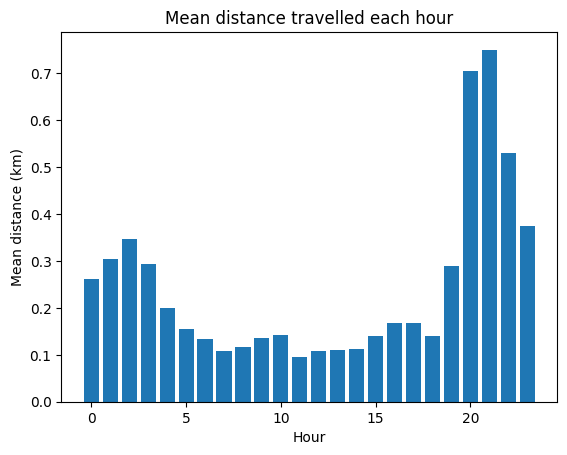

In [ ]:
import matplotlib.pyplot as plt
plt.bar(fox1_pd['hour'], fox1_pd['mean_dist'])
plt.title('Mean distance travelled each hour')
plt.xlabel('Hour')
plt.ylabel('Mean distance (km)')
plt.show()

### Open-ended task

<font color='blue'>**Task:** Perform any further exploratory analysis on the red fox dataset that you think might be interesting. As much processing as possible should be done via the PySpark DataFrame API, with minimal amounts of data being returned to the driver for plots/tables.</font>

**It is good practice to stop the underlying SparkContext when we are done**

In [ ]:
spark.stop()

In [ ]:
spark